# Modules


In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from skimage.feature import greycomatrix, greycoprops
from google.colab.patches import cv2_imshow

import cv2
import mahotas
import pickle 
import math
import os
from os import listdir
from os.path import isfile, join

# Utility Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def images_getter(path) :
  images = {}
  im2 = []

  for root, dirs, files in os.walk(path):
    path = root.split(os.sep)
    for index, file in enumerate(files):
        im2 = [ f for f in listdir(root) if isfile(join(root,f)) ]
        images[index] = join(root,im2[index])
  return images

In [ ]:
def append_images(path) :
  getter=images_getter(path)
  temp=[]
  for j in getter.values() :
    image=cv2.imread(j)
    temp.append(image)
  return temp
    

In [ ]:
def get_image(name, folder):
  filepath = os.path.join(folder, name)
  img = Image.open(filepath)
  return np.array(img)

def get_images(directoryName):
  directory = os.fsencode(directoryName)
  images = []
  for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"):
      image = get_image(filename, directoryName)
      images.append(image)
      continue
    else:
      continue
  return images

def fd_hu_moments(image):
  # Compute the Hu Moments of the image as a feature
  feature = cv2.HuMoments(cv2.moments(image)).flatten()
  feature[4] = feature[4] * 1e018
  feature[6] = feature[6] * 1e018
  return feature

def calc_glcm_all_agls(img, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
  glcm = greycomatrix(img,
                      distances=dists,
                      angles=agls,
                      levels=lvl,
                      symmetric=sym,
                      normed=norm)
  feature = []
  glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[
      0]]
  for item in glcm_props:
    feature.append(item)

  return feature

def fd_glcm(image):
  properties = ['dissimilarity', 'correlation',
                'homogeneity', 'contrast', 'ASM', 'energy']

  glcm_result = calc_glcm_all_agls(image,
                                    props=properties)
  return glcm_result

def convolute(input, kernel, pad_width=1, average=False):
  # initial values
  output = np.zeros(input.shape,dtype='uint8')
  # adding padding
  padding = np.pad(input, pad_width=pad_width, mode='constant', constant_values=0)
  for i in range(input.shape[0]):
    for j in range(input.shape[1]):
      for k in range(kernel.shape[0]):
        for l in range(kernel.shape[1]):
          output[i][j] += kernel[k][l]*padding[i+k][j+l]
          if average:
            output[i][j] /= kernel.shape[0] * kernel.shape[1]
  return output

def sharpen(image):
  sharpen_kernel = np.array([
      [-0.11, -0.11, -0.11],
    [-0.11, 1.89, -0.11],
    [-0.11,-0.11,-0.11]
  ],dtype='uint8')

  output = image.copy()

  output = convolute(image, sharpen_kernel)
  return output

def fd_histogram(image):
  hist = cv2.calcHist([image], [0], None, [256], [0, 256])
  cv2.normalize(hist, hist)
  hist = hist.flatten()
  return hist
  # Compute the histogram of the image as a feature
  cv2.normalize(hist, hist)
  hist = hist.flatten()
  return hist

def normalize_intensity(image, input_image):
  output = input_image.copy()
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      output[x, y] = int(math.floor(image[x, y]))
      if output[x, y] > 255:
        output[x, y] = 255
  return output
            

def getFeatures(image):
  return np.hstack([fd_histogram(image), fd_glcm(image), fd_hu_moments(image)])


# Data Loading & Preprocessing

In [ ]:
# Get features for the training images with masks
print("Processing training mask images")
mask_images = get_images("/content/drive/MyDrive/Kuliah/Semester 3/PCD/Assets/Final Project/mask_train")

mask_features = []
for image in mask_images:
  mask_features.append(getFeatures(image))
scaler = MinMaxScaler()

# Normalize The feature vectors...
mask_features = scaler.fit_transform(mask_features)

# Save features to a file
with open('mask_features.pkl', 'wb') as f:
  pickle.dump(mask_features, f)

print("Training Mask Features has shape:", np.shape(mask_features))

# Get features for the training images without masks
print("Processing training no mask images")
nomask_images = get_images("/content/drive/MyDrive/Kuliah/Semester 3/PCD/Assets/Final Project/unmask_train")

unnormalized_nomask_features_train = []
for image in nomask_images:
  unnormalized_nomask_features_train.append(getFeatures(image))

scaler = MinMaxScaler()
# Normalize The feature vectors...
nomask_features = scaler.fit_transform(unnormalized_nomask_features_train)

# Save features to a file
with open('nomask_features.pkl', 'wb') as f:
  pickle.dump(nomask_features, f)

print("Training No Mask Features has shape:", np.shape(nomask_features))

# Get features for test images with mask
print("Processing test mask images")
mask_images_test = get_images("/content/drive/MyDrive/Kuliah/Semester 3/PCD/Assets/Final Project/mask_test")

unnormalized_mask_features_test = []
for image in mask_images_test:
  unnormalized_mask_features_test.append(getFeatures(image))

scaler = MinMaxScaler()
# Normalize The feature vectors...
mask_features_test = scaler.fit_transform(unnormalized_mask_features_test)

# Save features to a file
with open('mask_features_test.pkl', 'wb') as f:
  pickle.dump(mask_features_test, f)
print("Testing Mask Features has shape:", np.shape(mask_features_test))

# Get features for test images without mask
print("Processing test no mask images")
nomask_images_test = get_images("/content/drive/MyDrive/Kuliah/Semester 3/PCD/Assets/Final Project/unmask_test")

unnormalized_nomask_features_test = []
for image in nomask_images_test:
  unnormalized_nomask_features_test.append(getFeatures(image))

scaler = MinMaxScaler()
# Normalize The feature vectors...
nomask_features_test = scaler.fit_transform(unnormalized_nomask_features_test)

with open('nomask_features_test.pkl', 'wb') as f:
  pickle.dump(nomask_features_test, f)

print("Testing No Mask Features has shape:",
        np.shape(nomask_features_test))

Processing training mask images
Training Mask Features has shape: (617, 287)
Processing training no mask images
Training No Mask Features has shape: (611, 287)
Processing test mask images
Testing Mask Features has shape: (68, 287)
Processing test no mask images
Testing No Mask Features has shape: (68, 287)


# Model Training

In [ ]:
# Read feature data from file
with open('mask_features.pkl', 'rb') as f:
  mask_features = pickle.load(f)

with open('nomask_features.pkl', 'rb') as f:
  nomask_features = pickle.load(f)

with open('mask_features_test.pkl', 'rb') as f:
  mask_features_test = pickle.load(f)

with open('nomask_features_test.pkl', 'rb') as f:
  nomask_features_test = pickle.load(f)

# Image labels. Mask = 1.0, No Mask = 0.0
mask_labels = [1.0 for i in mask_features]
nomask_labels = [0.0 for i in nomask_features]
mask_labels_test = [1.0 for i in mask_features_test]
nomask_labels_test = [0.0 for i in mask_features_test]

# Combine mask/no mask features for train and test set
X_train = np.concatenate([mask_features, nomask_features])
y_train = np.concatenate([mask_labels, nomask_labels])

X_test = np.concatenate([mask_features_test, nomask_features_test])
y_test = np.concatenate([mask_labels_test, nomask_labels_test])

# Train the SVM Model
print("Training...")
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)


Training...
Model accuracy is:  0.9044117647058824


# Model Testing

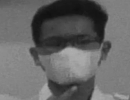

Wearing Mask


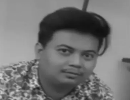

No Mask


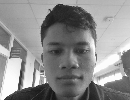

No Mask


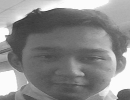

Wearing Mask


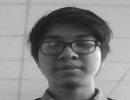

No Mask


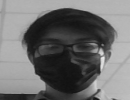

Wearing Mask


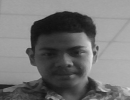

No Mask


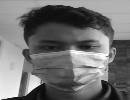

Wearing Mask


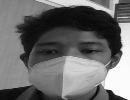

Wearing Mask


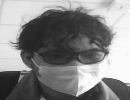

Wearing Mask


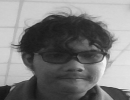

Wearing Mask


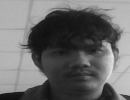

No Mask


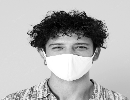

Wearing Mask


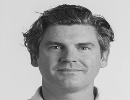

No Mask


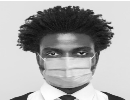

Wearing Mask


In [ ]:
classes = {0: "No Mask", 1: "Wearing Mask"}
(width, height) = (130, 100)
test_data = append_images("/content/drive/MyDrive/Kuliah/Semester 3/PCD/Assets/Final Project/custom/")
for data in test_data:
  gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
  gray = sharpen(gray)
  input_feature = np.array(getFeatures(
      gray))
  input_features = np.array(input_feature)
  input_features = input_features.reshape(1, -1)
  scaler.fit(np.concatenate([unnormalized_nomask_features_test, unnormalized_mask_features_test]))
  input_features = scaler.transform(input_features)
  y_pred = svm.predict(input_features)
  cv2_imshow(cv2.resize(gray, (width, height)))
  print(classes[y_pred[0]])